In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os, torch, gdown
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from matplotlib import pyplot as plt
import cv2
from utils import tensor_2_im

In [27]:
class ObjectDetectionCusomDataset(Dataset):
    def __init__(self, root, transformations =None):
        super(). __init__()
        self.transformations = transformations
        self.im_path = sorted(glob(f"{root}/PNGImages/*.png"))
        self.mask_path = sorted(glob(f"{root}/PedMasks/*.png"))
        self.number_class = 2
        
        
    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):
        im = Image.open(self.im_path[idx]).convert("RGB")
        gt = np.array(Image.open(self.mask_path[idx]))
        # print(np.unique(gt)[1:])
        obj_index = np.unique(gt)[1:]
        print(obj_index)
        mask =gt ==obj_index[:, None, None]
        # print(mask)
        # print(obj_index[:, None, None])
        obj_soni = len(obj_index)
        bounding_bos = []
        for idx, box in enumerate(mask):
  
            pos = np.where(box)
            x1 = np.min(pos[1])
            x2 = np.max(pos[1])
            y1 = np.min(pos[0])
            y2 = np.max(pos[0])
            bounding_bos.append([x1,y1, x2, y2])
           
        bounding_box = torch.as_tensor(bounding_bos, dtype = torch.float32)    
        # print(bounding_bos)
        labels = torch.ones((obj_soni), dtype = torch.int64)
        mask = torch.as_tensor(mask, dtype = torch.uint8)
        im_id = torch.tensor([idx])
        area = (bounding_box[:,3] - bounding_box[:, 1]) * (bounding_box[:,2] - bounding_box[:, 0])
        is_crowd = torch.zeros((obj_soni), dtype = torch.int64)

        answer = {}
        answer["boxes"] = bounding_box
        answer["labels"] = labels
        answer["masks"] = mask
        answer["image_id"] = im_id
        answer["area"] = area
        answer["iscrowd"] = is_crowd
       
        if self.transformations :
            im, answer = self.transformations(im, answer)
            

        return im, answer

root = 'data'        
ds = ObjectDetectionCusomDataset(root=root)   
ds[104]

[1]


(<PIL.Image.Image image mode=RGB size=487x340>,
 {'boxes': tensor([[243.,  41., 389., 328.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([41902.]),
  'iscrowd': tensor([0])})

In [3]:
from torch import Tensor
from torchvision.transforms import functional as F, transforms as T

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for tr in self.transforms:
            image, target = tr(image, target)
        return image, target

class PIL2tensor(torch.nn.Module):
    def forward(self, image, target):
        image = F.pil_to_tensor(image)
        return image, target

class Normalize(torch.nn.Module):
    def forward(self, image, target):
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        image = F.normalize(tensor=image, mean=mean, std=std)
        return image, target

class ConvertImageDType(torch.nn.Module):
    def __init__(self, dtype):
        super().__init__()
        self.dtype = dtype

    def forward(self, image, target):
        image = F.convert_image_dtype(image, self.dtype)
        return image, target

def get_transformations():
    transformations = []
    transformations.append(PIL2tensor())
    transformations.append(ConvertImageDType(dtype=torch.float))
    transformations.append(Normalize())
    
    return Compose(transforms = transformations)
def collate(batch): return tuple(zip(*batch))

def get_dlr(root, transformations, bs, split = [0.8, 0.1]):
    ds = ObjectDetectionCusomDataset(root=root, transformations = transformations)
    ds_len = len(ds)
    tr_len = int(ds_len*split[0])
    vl_len = int(ds_len*split[1])
    ts_len = ds_len - (tr_len+vl_len)

    tr_ds, val_ds, ts_ds = random_split(dataset= ds, lengths= [tr_len, vl_len, ts_len])
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, collate_fn = collate, shuffle = True, num_workers = 0)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, collate_fn = collate, shuffle = False, num_workers = 0)
    ts_dl = DataLoader(dataset = ts_ds, batch_size = 1, collate_fn = collate, shuffle = False, num_workers = 0)
    
    return tr_dl, val_dl, ts_dl, ds.number_class

tfs = get_transformations()

tr_dl, val_dl, ts_dl, classes = get_dlr(root =root, transformations = tfs, bs = 6)
print(len(tr_dl)) 
print(len(val_dl))
print(len(ts_dl))


23
3
17


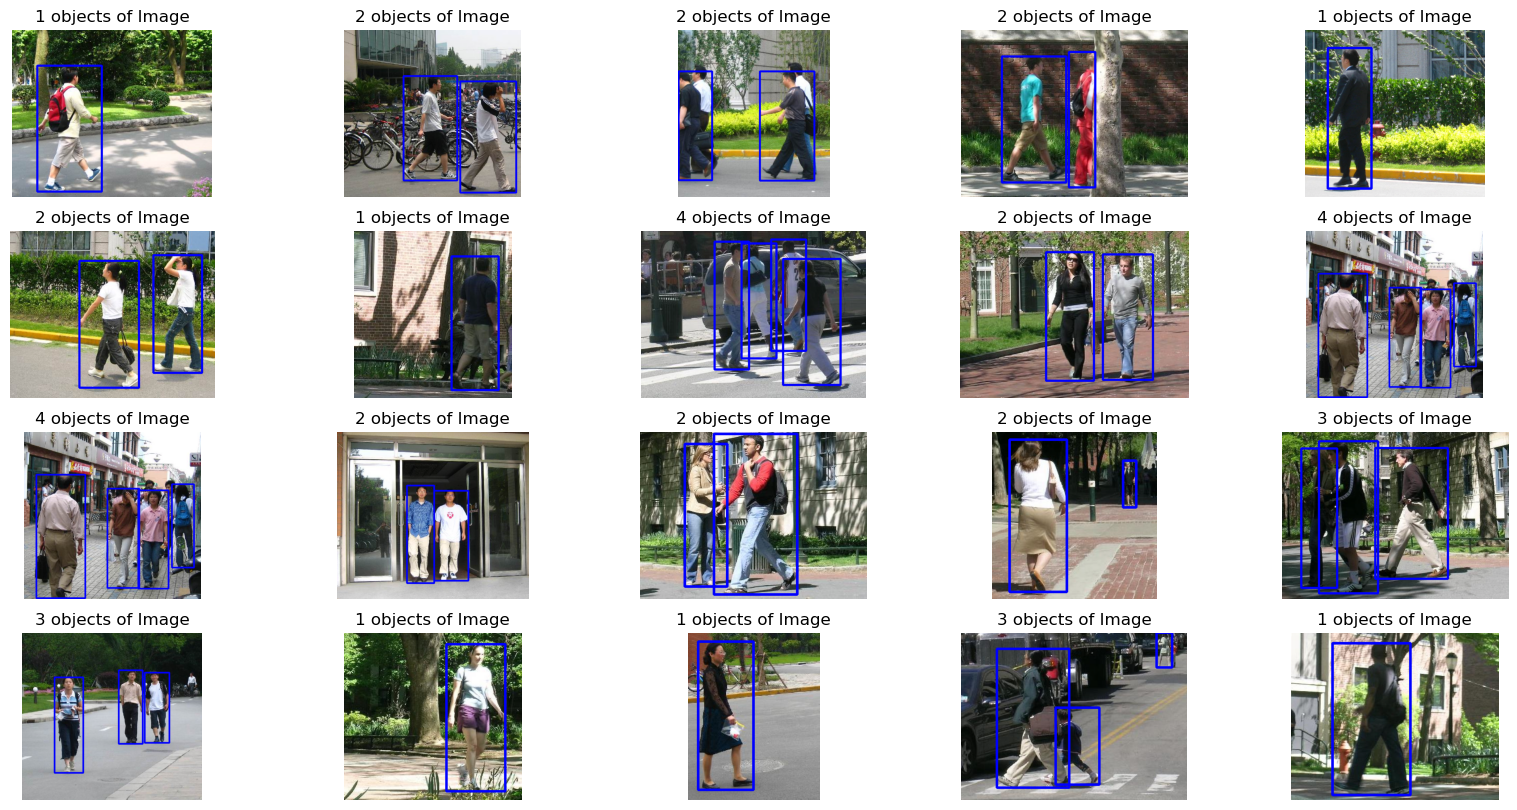

In [4]:
import datetime
import errno
import os
import time, cv2
from matplotlib import pyplot as plt
from collections import defaultdict, deque

import torch, random
import torch.distributed as dist
from torchvision import transforms as tfs
import numpy as np
from torchvision import transforms as tfs
def tensor_2_im(t, t_type = "rgb", inv_trans = False):
    
    assert t_type in ["rgb", "gray"], "Rasm RGB yoki grayscale ekanligini aniqlashtirib bering."
    
    gray_tfs = tfs.Compose([tfs.Normalize(mean = [ 0.], std = [1/0.5]), tfs.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = tfs.Compose([tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if inv_trans else (t * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)


def visualize(data, n_ims,  rows ,cmap = None):
    plt.figure(figsize=(20, 10))
    index = [random.randint(0, len(data)-1) for _ in range(n_ims)]
    for idx, idxs in enumerate(index):
        im, gt = data[idxs]
        img = tensor_2_im(im, inv_trans= True)
        obj_num = 0
        for i, bbox in enumerate(gt["boxes"]):
            x,y,w,h = [int(t.item()) for t in bbox]
            obj_num += 1
            
            cv2.rectangle(img = img, pt1 = (x, y), pt2 = (w, h), color = (0, 0, 255), thickness = 3)
        plt.subplot(rows, n_ims// rows, idx +1)
        plt.imshow(img); plt.title(f"{obj_num} objects of Image"); plt.axis("off")
            
            
visualize(data = tr_dl.dataset, n_ims= 20,  rows = 4)

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

m = fasterrcnn_resnet50_fpn(weights = "DEFAULT")
device, num_classes = "cuda", classes

# get number of input features for the classifier
in_features = m.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
m.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features, num_classes)
m.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features, num_classes * 4)
m.to(device)
optimizer = torch.optim.SGD(m.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [6]:
import torch.distributed as dist, datetime
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask_util
from contextlib import redirect_stdout
import copy, io

class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            raise TypeError(f"This constructor expects iou_types of type list or tuple, instead  got {type(iou_types)}")
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate_coco(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        if iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        if iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        raise ValueError(f"Unknown iou type {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "keypoints": keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


def evaluate_coco(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list

In [7]:
import math, sys, time, torch, torchvision
import torchvision.models.detection.mask_rcnn
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from collections import defaultdict, deque

def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"].clone()
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if "keypoints" in targets:
            keypoints = targets["keypoints"]
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if "keypoints" in targets:
                ann["keypoints"] = keypoints[i]
                ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
            dataset["annotations"].append(ann)
            ann_id += 1
    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds

def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler = None):
    model.train()
    metric_logger = MetricLogger(delimiter=" | ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"{epoch + 1}-epochdagi "

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for idx, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images = list(image.to(device) for image in images)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # change here
        
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        
        if not math.isfinite(loss_value):
            print(f"Loss {loss_value} bo'lgani uchun train jarayonini to'xtatamiz...")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

# @torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter=" | ")
    header = "Test jarayoni: "

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available(): torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)      
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_vaqt=model_time, baholash_vaqt=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print(f"\nTest jarayoni statistikasi: {metric_logger}\n")
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    
    return coco_evaluator

class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )

class MetricLogger:
    def __init__(self, delimiter=" | "):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            init_msg = "".join(
                [
                    f"\n{header}",
                    "{1}ta batchdan {0" + space_fmt +"}-sining natijasi: \n",
                ]
            )
            
            log_msg = self.delimiter.join(
                [
                    "{meters}",
                    "vaqt -> {time}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "vaqt: {vaqt}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(init_msg.format(i + 1, len(iterable)))
                    print(
                        log_msg.format(
                            meters=str(self),
                            time=str(iter_time),
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} umumiy vaqt: {total_time_str} ({total_time / len(iterable):.4f} s / rasm)")
        
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [8]:
model_prefix = "people"
epochs = 10
save_model_path = "saved_models"
for epoch in range(epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(m, optimizer, tr_dl, device, epoch, print_freq = 10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(m, val_dl, device = device)

os.makedirs(f"{save_model_path}", exist_ok = True)
torch.save(m, f"{save_model_path}/{model_prefix}_best_model.pt")
print("Train jarayoni yakunlandi!")


1-epochdagi 23ta batchdan  1-sining natijasi: 

lr: 0.000046 | loss: 0.7895 (0.7895) | loss_classifier: 0.4930 (0.4930) | loss_box_reg: 0.0818 (0.0818) | loss_objectness: 0.2001 (0.2001) | loss_rpn_box_reg: 0.0146 (0.0146) | vaqt -> 3.2776

1-epochdagi 23ta batchdan 11-sining natijasi: 

lr: 0.000501 | loss: 0.4700 (0.5498) | loss_classifier: 0.2374 (0.3063) | loss_box_reg: 0.1554 (0.1386) | loss_objectness: 0.0252 (0.0852) | loss_rpn_box_reg: 0.0167 (0.0197) | vaqt -> 13.0310

1-epochdagi 23ta batchdan 21-sining natijasi: 

lr: 0.000955 | loss: 0.4560 (0.5225) | loss_classifier: 0.2050 (0.2598) | loss_box_reg: 0.1955 (0.1842) | loss_objectness: 0.0243 (0.0601) | loss_rpn_box_reg: 0.0165 (0.0183) | vaqt -> 17.4273

1-epochdagi 23ta batchdan 23-sining natijasi: 

lr: 0.001000 | loss: 0.4264 (0.5072) | loss_classifier: 0.2012 (0.2499) | loss_box_reg: 0.1975 (0.1836) | loss_objectness: 0.0187 (0.0560) | loss_rpn_box_reg: 0.0165 (0.0177) | vaqt -> 17.3678
1-epochdagi  umumiy vaqt: 0:05:53

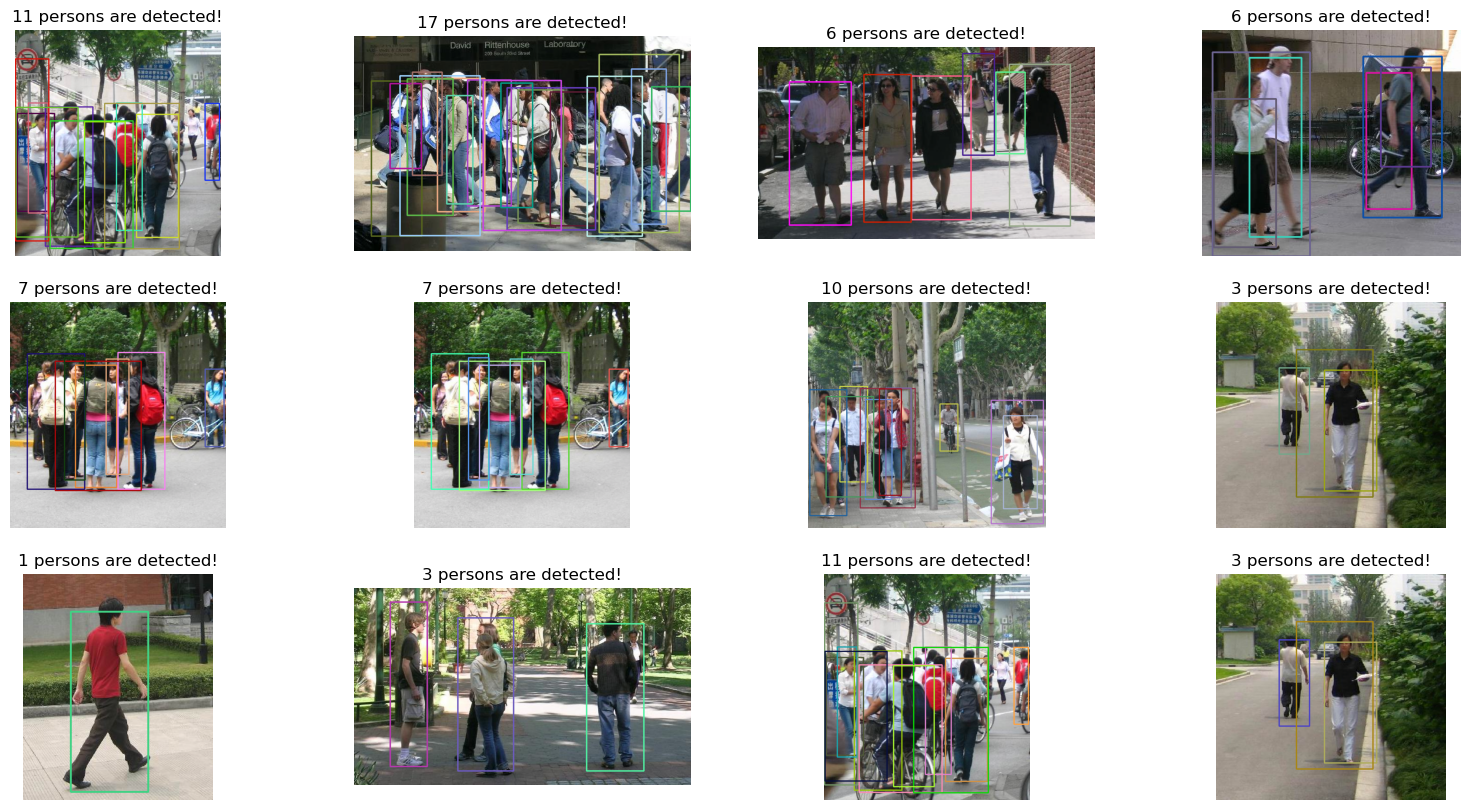

In [14]:
def inference(model, ts_dl, num_ims, rows, threshold = 0.55, cmap = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(ts_dl) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        im, _ = ts_dl.dataset[indeks]
        with torch.no_grad(): predictions = m(im.unsqueeze(0).to(device))
        img = tensor_2_im(im, inv_trans = True)
        obj_count = 0
        for i, (boxes, scores, labels) in enumerate(zip(predictions[0]["boxes"], predictions[0]["scores"], predictions[0]["labels"])):
            if scores > threshold:
                obj_count += 1
                r, g, b = [random.randint(0, 255) for _ in range(3)]
                x, y, w, h = [round(b.item()) for b in boxes]
                cv2.rectangle(img = img, pt1 = (x, y), pt2 = (w, h), color = (r, g, b), thickness = 2)
        plt.subplot(rows, num_ims // rows, idx + 1)
        plt.imshow(img); plt.title(f"{obj_count} persons are detected!")
        plt.axis("off")

m = torch.load(f"{save_model_path}/{model_prefix}_best_model.pt")
# m = torch.load("saved_models/vehicles_test_best_model.pt")
inference(model = m, ts_dl = ts_dl, num_ims = 12, rows = 3, cmap = "rgb")